In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

labels = pd.read_table('/content/drive/MyDrive/data/gdsc/kaggle_Garbage Classification/one-indexed-files.txt', sep = " ", 
                       names = ["file_name", "labels"])

plastic220.jpg
image shape : (384, 512, 3)
cardboard333.jpg
image shape : (384, 512, 3)
glass280.jpg
image shape : (384, 512, 3)
paper582.jpg
image shape : (384, 512, 3)
metal232.jpg
image shape : (384, 512, 3)
trash101.jpg
image shape : (384, 512, 3)


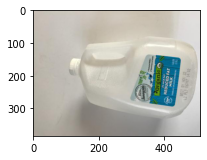

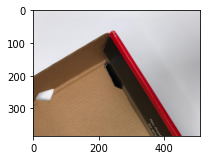

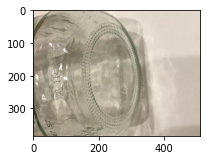

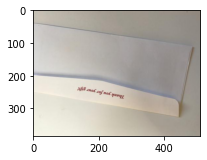

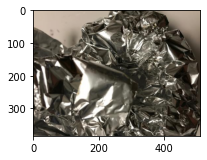

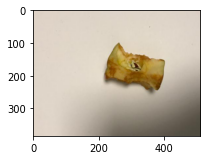

In [ ]:
import os
import matplotlib.image as mpimg

url = '/content/drive/MyDrive/data/gdsc/kaggle_Garbage Classification/Garbage classification/Garbage classification'
cat = os.listdir(url)
for i in cat:
  lists = os.listdir(url+'/'+i)[0]
  path = url+'/'+i+'/'+lists

  image = mpimg.imread(path)
  f, ax = plt.subplots(figsize = (3,3))
  plt.imshow(image)
  print(lists)
  print('image shape : {}'.format(image.shape))


  # 사진크기 w = 512, h = 384, rgb = 3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range = 10,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = (0.75, 1.05),
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    fill_mode = 'constant',
    brightness_range = (0.55, 0.9),
    validation_split = 0.2)

val_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

########################################################################################

train_generator = train_gen.flow_from_directory(
    url,
    target_size = (384, 512),
    subset = 'training',
    class_mode = 'categorical',
    classes = ['cardboard', 'glass', 'metal','paper', 'plastic', 'trash'],
    batch_size = 64
)

########################################################################################

val_generator = val_gen.flow_from_directory(
    url,
    target_size = (384, 512),
    subset = 'validation',
    class_mode = 'categorical',
    classes = ['cardboard', 'glass', 'metal','paper', 'plastic', 'trash'],
    batch_size = 64
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D , Dropout , Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD


def cnn_model(filter, width, height, ch = 3):
  inputs = Input(shape = (width, height, ch))
  conv1 = Conv2D(filters = filter, kernel_size = (3, 3),activation = "relu")(inputs)
  bn = BatchNormalization()(conv1)
  mx_pl = MaxPooling2D((2,2))(bn)
  drop_out = Dropout(0.25)(mx_pl)
  
  conv2 = Conv2D(filters = filter*2, kernel_size = (4, 4), activation = "relu")(drop_out)
  bn2 = BatchNormalization()(conv2)
  mx_pl2 = MaxPooling2D((2,2))(bn2)
  drop_out2 = Dropout(0.25)(mx_pl2)

  conv3 =  Conv2D(filters = filter*4, kernel_size = (3, 3), activation = "relu")(drop_out2)
  bn3 = BatchNormalization()(conv3)
  mx_pl3 = MaxPooling2D((2,2))(bn3)
  drop_out3 = Dropout(0.25)(mx_pl3)

  flatten = GlobalAveragePooling2D()(drop_out3)
  dense1 = Dense(256, activation = "relu")(flatten)
  bn4 = BatchNormalization()(dense1)
  drop_out4 = Dropout(0.5)(bn4)
  output = Dense(6, activation = "softmax")(drop_out4)

  model = Model(inputs = inputs, outputs = output)

  rms = RMSprop(learning_rate = 0.001, decay = 1e-6)
  model.compile(loss = 'categorical_crossentropy', optimizer = rms, metrics = ['accuracy'])

  return model


In [ ]:
model = cnn_model(32, width = 512, height = 384)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 384, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 510, 382, 32)      896       
                                                                 
 batch_normalization_15 (Bat  (None, 510, 382, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 255, 191, 32)     0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 255, 191, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 252, 188, 64)      3283

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(patience = 10)
reducing = ReduceLROnPlateau(monitor = 'val_accuracy',
                             patience = 2,
                             verbose = 0.5,
                             min_lr = 0.0001)

cp = ModelCheckpoint('/content/drive/MyDrive/data/gdsc',
                     save_weights_only = True,
                     verbose = 1)


callbacks = [early_stop, reducing, cp]

In [ ]:
history = model.fit(train_generator, 
                    epochs = 50, 
                    validation_data = val_generator,
                    callbacks = callbacks)

Epoch 1/50
127/127 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9170
Epoch 00001: saving model to /content/drive/MyDrive/data/gdsc
127/127 [==============================] - 394s 3s/step - loss: 0.2183 - accuracy: 0.9170 - val_loss: 0.6899 - val_accuracy: 0.7853 - lr: 1.0000e-05
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9244
Epoch 00002: saving model to /content/drive/MyDrive/data/gdsc
127/127 [==============================] - 400s 3s/step - loss: 0.2105 - accuracy: 0.9244 - val_loss: 0.6675 - val_accuracy: 0.7913 - lr: 1.0000e-05
Epoch 3/50
127/127 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9180
Epoch 00003: saving model to /content/drive/MyDrive/data/gdsc
127/127 [==============================] - 397s 3s/step - loss: 0.2253 - accuracy: 0.9180 - val_loss: 0.6860 - val_accuracy: 0.7932 - lr: 1.0000e-05
Epoch 4/50
127/127 [==============================] - ETA: 0s - loss: 0.2114 - 

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionResNetV2

inc = InceptionResNetV2(weights = 'imagenet', input_shape = (384, 512, 3), include_top = False)
inc.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 191, 255, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 191, 255, 32  96         ['conv2d[0][0]']                 
 alization)  

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

global_average_layer = GlobalAveragePooling2D()
inc.trainable = False

inputs = Input(shape = (384, 512, 3))
x = inc(inputs ,training = False)
x = global_average_layer(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(6, activation = "softmax")(x)
model = Model(inputs, outputs)

sgd = SGD(learning_rate = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
rms = RMSprop(learning_rate = 0.01, decay = 1e-6)
ad = Adam(learning_rate = 0.001, decay = 1e-6)

model.compile(loss = 'categorical_crossentropy', optimizer = ad, metrics = ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 10, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                98368     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 6)                 390 

In [ ]:
history = model.fit(train_generator, 
                    epochs = 50, 
                    validation_data = val_generator,
                    callbacks = callbacks)

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6576
Epoch 00001: saving model to /content/drive/MyDrive/data/gdsc
32/32 [==============================] - 152s 4s/step - loss: 0.9789 - accuracy: 0.6576 - val_loss: 0.6934 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.8068
Epoch 00002: saving model to /content/drive/MyDrive/data/gdsc
32/32 [==============================] - 136s 4s/step - loss: 0.5622 - accuracy: 0.8068 - val_loss: 0.6316 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.8231
Epoch 00003: saving model to /content/drive/MyDrive/data/gdsc
32/32 [==============================] - 136s 4s/step - loss: 0.5020 - accuracy: 0.8231 - val_loss: 0.5671 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8508
Epoch 000

In [ ]:
pred = np.argmax(model.predict(val_generator), axis = 1)

- 어렵구만........

In [ ]:
model.save('/content/drive/MyDrive/data/gdsc/model_85.h5')

# model 정확도가 85%가 최대이다.
# 데이터가 부족하기도하고 모바일넷 자체적으로 큰 모델이 아니기때문에 정확도가 더 올라가는건 어려웠던거같다.

- 생각보다 많이 배우게 되었다.
   - pre-trained model을 사용해봤고 image augmentation의 구조를 잘알게 되었다(뜯어보면서 어떻게 적용되는지 알 수 있었음)